In [1]:
import pytesseract as pt
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pdf2image import convert_from_path

In [29]:
def area(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x)-min(x))*(max(y)-min(y))

def start_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(y))

def end_point(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (max(x),min(y))

def get_points(approx):
    x = approx[:,0,0]
    y = approx[:,0,1]
    return (min(x),max(x),min(y),max(y))

def get_all_points(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
#                 cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return coordinates

def get_tables(image):
    coordinates = get_all_points(image)
    # print(len(coordinates))
    tables = []
    for coordinate in coordinates:
        tables.append(image[coordinate[2]:coordinate[3],coordinate[0]:coordinate[1]])
    return tables

def get_image_with_table(img):
    image = img
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    coordinates = []
    for contour in contours:
        epsilon = 0.05 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        if len(approx) == 4:
            if (area(approx)>5000):
                coordinates.append(get_points(approx))
#                 print(area(approx))
                cv2.rectangle(image, start_point(approx),end_point(approx), (0, 255, 255), 5)
    return image

In [36]:
# 15,15,40,40
def get_cells_coordinates(image,v_erode,v_dilate,h_erode,h_dilate):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=v_erode)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=v_dilate)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=h_erode)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=h_dilate)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))
    
#     plt.imshow(vertical_horizontal_lines)
#     plt.show()

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    return vertical_horizontal_lines

def get_text_csv(bounding_boxes,image):
#     print(bounding_boxes)
    cols = len(np.unique(np.array(bounding_boxes)[:,0]))
    rows = len(np.unique(np.array(bounding_boxes)[:,1]))
    
    rows_start_points = sorted(np.unique(np.array(bounding_boxes)[:,1]))
    cols_start_points = sorted(np.unique(np.array(bounding_boxes)[:,0]))
    rows_end_points = sorted(np.unique(np.array(bounding_boxes)[:,1]+np.array(bounding_boxes)[:,3]))
    cols_end_points = sorted(np.unique(np.array(bounding_boxes)[:,0]+np.array(bounding_boxes)[:,2]))
    
    table = []
    for i in range(rows):
        table.append([])
        for j in range(cols):
            table[i].append(())

    for idx,box in enumerate(bounding_boxes):
        col_start, row_start, w, h = box
        row_end, col_end = row_start+h,col_start+w
        #     print(rows_start_points.index(row_start)-rows_end_points.index(row_end))
        for i in range(rows_start_points.index(row_start),rows_end_points.index(row_end)+1):
            for j in range(cols_start_points.index(col_start),cols_end_points.index(col_end)+1):
                table[i][j]=box
#                 print(i,j,idx)
#     display_cell(image,table[7][0])
    # text = []
    all_text = ''
    for idx,row in enumerate(table):
    #     text.append([])
        for cell in row:
#             print(cell)
            x, y, w, h = cell
            ocr_text = pt.image_to_string(image[y:y+h,x:x+w],config='--psm 6',
                                          lang='pan').replace('\n','').replace('\x0c','').replace('_','')
#             print(ocr_text)
            all_text = all_text+ocr_text+','
        #         text[idx].append(ocr_text)
        all_text=all_text+'\n'
    return all_text

In [4]:
def get_cells_coordinates_include_verification(image,v_erode,v_dilate,h_erode,h_dilate):
    img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
    img = cv2.bitwise_not(img)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
    hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

    vertical_lines = cv2.erode(img, vertical_kernel, iterations=v_erode)
    vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=v_dilate)

    horizontal_lines = cv2.erode(img, hor_kernel, iterations=h_erode)
    horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=h_dilate)

    vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
    vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

    thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
    b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))

    contours, hierarchy = cv2.findContours(vertical_horizontal_lines, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    temp_bound_box = [cv2.boundingRect(c) for c in contours]
    (contours, temp_bound_box) = zip(*sorted(zip(contours, temp_bound_box),key=lambda x:x[1][1]))
    boundingBoxes=[]
    for box in temp_bound_box:
#         print(box)
        boundingBoxes.append(box)
    print(boundingBoxes[0][2:],(np.shape(image)[1],np.shape(image)[0]))
    if (boundingBoxes[0][2]==np.shape(image)[1] and np.shape(image)[0]==boundingBoxes[0][3]):
        print('same')
        return boundingBoxes[1:]
    if (np.shape(image)[1]-boundingBoxes[0][2]>200 or
              np.shape(image)[0]-boundingBoxes[0][3]>200):
        return boundingBoxes
    x = input()
    if (x=='n'):
        return boundingBoxes
    return boundingBoxes[1:]

In [6]:
book = 'data_books/punjabi/pp_rabi_pbi_table.pdf'
images = convert_from_path(book,dpi=300)
tables = [get_tables(np.array(image)) for image in images]

In [106]:
input_str = "3 4 13 16 22 23 24 25 26 27 33 54 55"
input_str = input_str.split()
error_page = [int(num) for num in input_str]

In [113]:
final_error=[5,10,12,20,32,48,61]

In [115]:
table_to_be_edited = [tables[i] for i in error_page]

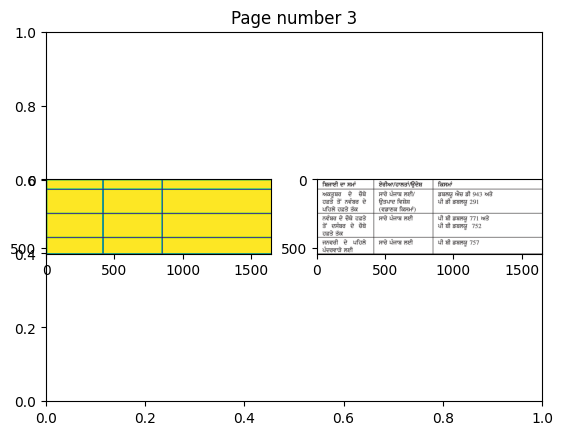

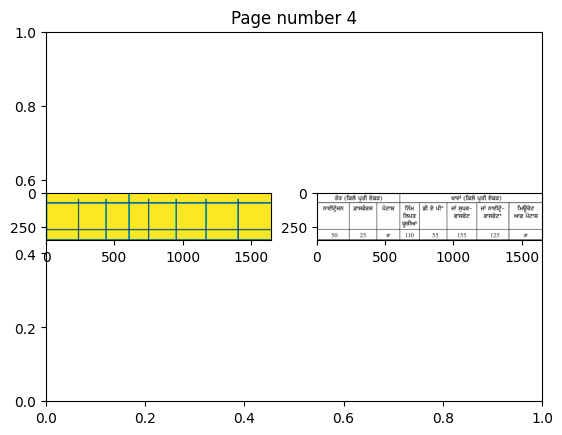

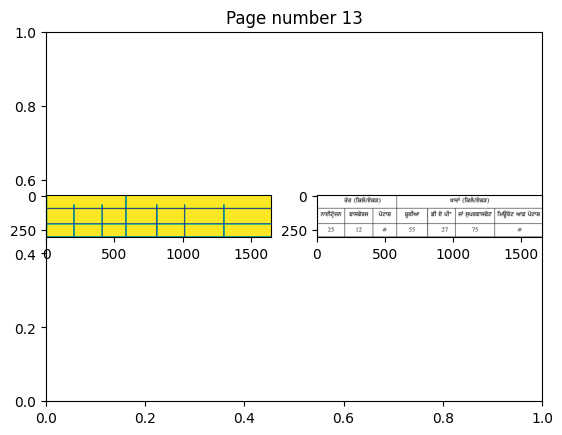

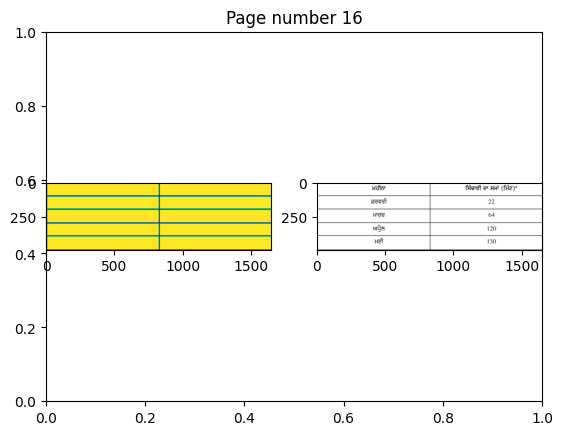

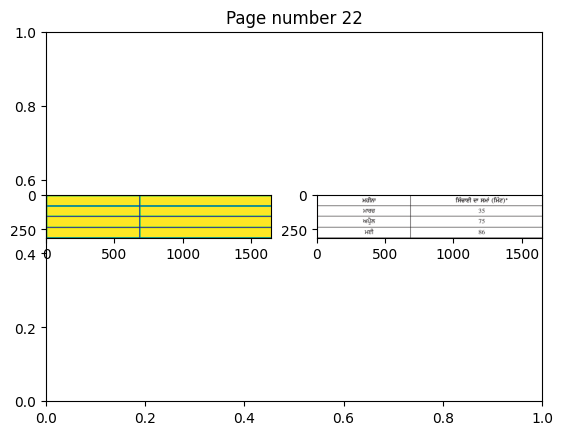

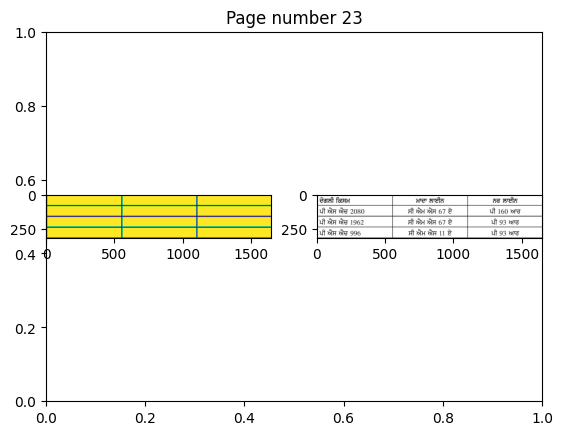

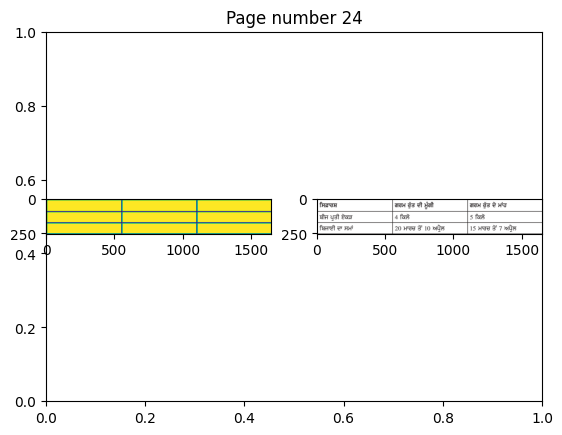

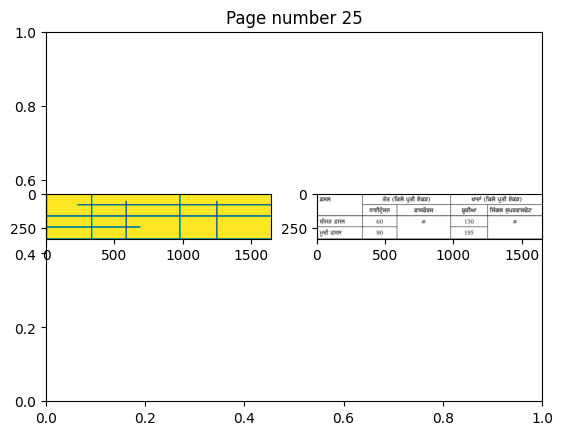

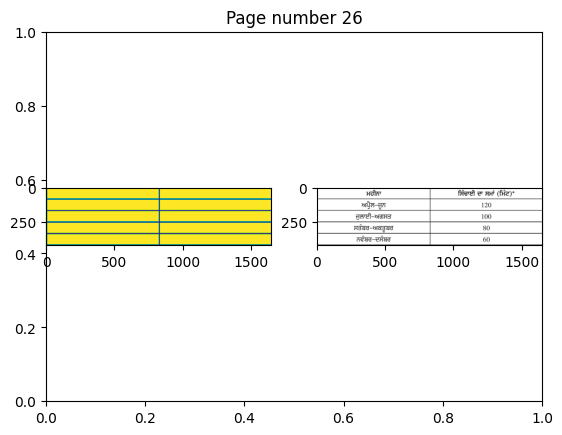

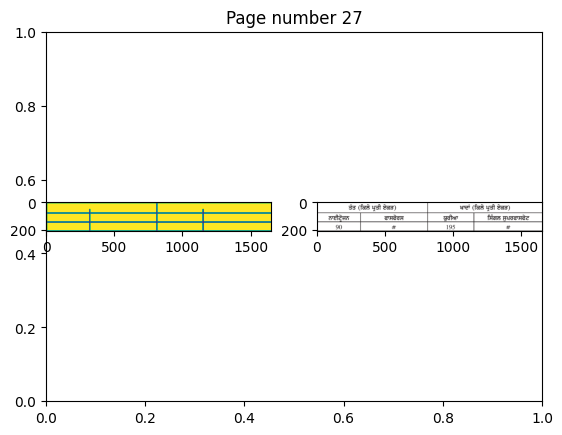

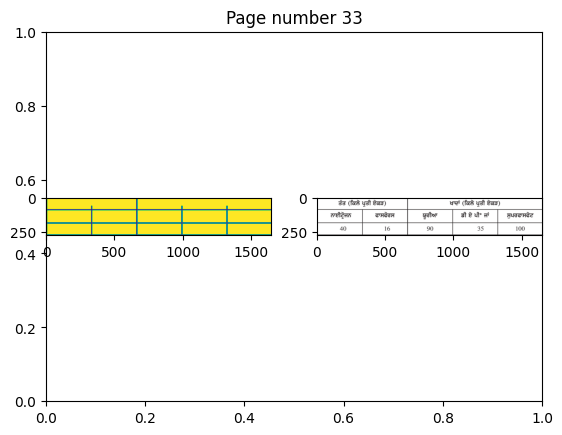

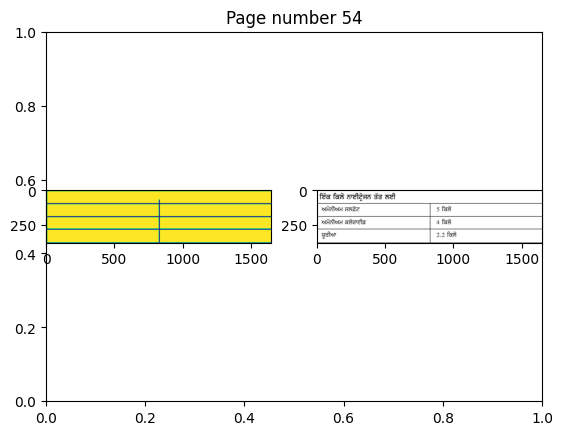

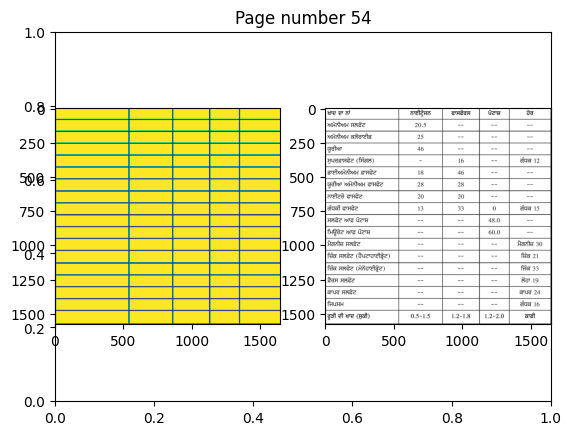

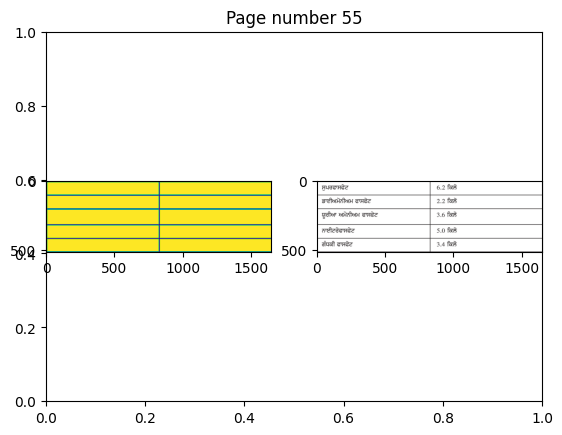

In [116]:
for idx,page in enumerate(table_to_be_edited):
    for table in page:
        plt.title(f'Page number {error_page[idx]}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table,15,15,40,40))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [117]:
all_text = ''
for idx,table in enumerate(table_to_be_edited):
    all_text = all_text + f'page-{error_page[idx]}\n'
#     print(len(table))
    if (len(table)>3):
        print(error_page[idx],len(table))
    else:
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,15,15,40,40)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                print(ocr)
            except:
                continue
    all_text = all_text + '\n\n\n\n'

(795, 1) (1650, 543)
,,,,
,ਬਿਜਾਈ ਦਾ ਸਮਾਂ,ਏਰੀਆ/ਹਾਲਤਾਂ/ਉਦੇਸ਼,ਕਿਸਮਾਂ,
,ਅਕਤੂਬਰ ਦੇ ਚੌਥੇਹਫ਼ਤੇ ਤੋਂ ਨਵੰਬਰ ਦੇਪਹਿਲੇ ਹਫ਼ਤੇ ਤੱਕ,ਸਾਰੇ ਪੰਜਾਬ ਲਈ/ਉਤਪਾਦ ਵਿਸ਼ੇਸ਼(ਵਡਾਣਕ ਕਿਸਮਾਂ),ਡਬਲਯੂ ਐਚ ਡੀ 943 ਅਤੇਪੀ ਡੀ ਡਬਲਯੂ 291,
,ਨਵੰਬਰ ਦੇ ਚੌਥੇ ਹਫ਼ਤੇਤੋਂ ਦਸੰਬਰ ਦੇ ਚੌਥੇਹਫ਼ਤੇ ਤੌਕ,ਸਾਰੇ ਪੰਜਾਬ ਲਈ,ਪੀ ਬੀ ਡਬਲਯੂ 771 ਅਤੇਪੀ ਬੀ ਡਬਲਯੂ 752,
,ਜਨਵਰੀ ਦੇ ਪਹਿਲੇਪੰਦਰਵਾੜੇ ਲਈ,ਸਾਰੇ ਪੰਜਾਬ ਲਈ,ਪੀ ਬੀ ਡਬਲਯੂ 757,

(1037, 1) (1650, 349)
,,,,,,,,,
,ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),
,ਨਾਈਟ੍ਰੋਜਨ,ਫ਼ਾਸਫੋਰਸ,ਪੋਟਾਸ਼,ਨਿੰਮਲਿਪਤਯੂਰੀਆ,ਡੀ ਏ ਪੀ",ਜਾਂ ਸੁਪਰ-ਫਾਸਫੇਟ,ਜਾਂ ਨਾਈਟੋ-ਫਾਸਫੇਟ",ਮਿਊਰੇਟਆਫ਼ ਪੋਟਾਸ਼,
,50,25,ਤੱ,110,55,155,125,ਤੱ,

(1060, 1) (1652, 308)
,,,,,,,,
,ਤੱਤ (ਕਿਲੋ/ਏਕੜ),ਤੱਤ (ਕਿਲੋ/ਏਕੜ),ਤੱਤ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),
,ਨਾਈਟੋਜਨ,ਫਾਸਫੋਰਸ,ਪੋਟਾਸ਼,ਯੂਰੀਆ,ਡੀ ਏ ਪੀ",ਜਾਂ ਸੁਪਰਫਾਸਫੇਟ,ਮਿਊਰੇਟ ਆਫ਼ ਪੋਟਾਸ਼,
,25,12,ਤੱ,55,27,75,ਤੱ,

(816, 1) (1650, 491)
,,,
,ਮਹੀਨਾ,ਸਿੰਚਾਈ ਦਾ ਸਮਾਂ (ਮਿੰਟ)",
,ਫ਼ਰਵਰੀ,22,
,ਮਾ

In [118]:
print(all_text)

page-3
,,,,
,ਬਿਜਾਈ ਦਾ ਸਮਾਂ,ਏਰੀਆ/ਹਾਲਤਾਂ/ਉਦੇਸ਼,ਕਿਸਮਾਂ,
,ਅਕਤੂਬਰ ਦੇ ਚੌਥੇਹਫ਼ਤੇ ਤੋਂ ਨਵੰਬਰ ਦੇਪਹਿਲੇ ਹਫ਼ਤੇ ਤੱਕ,ਸਾਰੇ ਪੰਜਾਬ ਲਈ/ਉਤਪਾਦ ਵਿਸ਼ੇਸ਼(ਵਡਾਣਕ ਕਿਸਮਾਂ),ਡਬਲਯੂ ਐਚ ਡੀ 943 ਅਤੇਪੀ ਡੀ ਡਬਲਯੂ 291,
,ਨਵੰਬਰ ਦੇ ਚੌਥੇ ਹਫ਼ਤੇਤੋਂ ਦਸੰਬਰ ਦੇ ਚੌਥੇਹਫ਼ਤੇ ਤੌਕ,ਸਾਰੇ ਪੰਜਾਬ ਲਈ,ਪੀ ਬੀ ਡਬਲਯੂ 771 ਅਤੇਪੀ ਬੀ ਡਬਲਯੂ 752,
,ਜਨਵਰੀ ਦੇ ਪਹਿਲੇਪੰਦਰਵਾੜੇ ਲਈ,ਸਾਰੇ ਪੰਜਾਬ ਲਈ,ਪੀ ਬੀ ਡਬਲਯੂ 757,





page-4
,,,,,,,,,
,ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),
,ਨਾਈਟ੍ਰੋਜਨ,ਫ਼ਾਸਫੋਰਸ,ਪੋਟਾਸ਼,ਨਿੰਮਲਿਪਤਯੂਰੀਆ,ਡੀ ਏ ਪੀ",ਜਾਂ ਸੁਪਰ-ਫਾਸਫੇਟ,ਜਾਂ ਨਾਈਟੋ-ਫਾਸਫੇਟ",ਮਿਊਰੇਟਆਫ਼ ਪੋਟਾਸ਼,
,50,25,ਤੱ,110,55,155,125,ਤੱ,





page-13
,,,,,,,,
,ਤੱਤ (ਕਿਲੋ/ਏਕੜ),ਤੱਤ (ਕਿਲੋ/ਏਕੜ),ਤੱਤ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ/ਏਕੜ),
,ਨਾਈਟੋਜਨ,ਫਾਸਫੋਰਸ,ਪੋਟਾਸ਼,ਯੂਰੀਆ,ਡੀ ਏ ਪੀ",ਜਾਂ ਸੁਪਰਫਾਸਫੇਟ,ਮਿਊਰੇਟ ਆਫ਼ ਪੋਟਾਸ਼,
,25,12,ਤੱ,55,27,75,ਤੱ,





page-16
,,,
,ਮਹੀਨਾ,ਸਿੰਚਾਈ ਦਾ ਸਮਾਂ (ਮਿੰਟ)",
,ਫ਼ਰਵਰੀ,22,
,ਮਾਰਚ,64,
,ਅਪ੍ਰੈਲ,120,
,ਮਈ,130,





page-22
,,

In [119]:
output_file = 'data_books/ocr_punjabi/pp_rabi_tables_error_update.txt'
f=open(output_file,'w')
f.write(all_text)
f.close()

In [120]:
final_table_to_be_edited = [tables[i] for i in final_error]

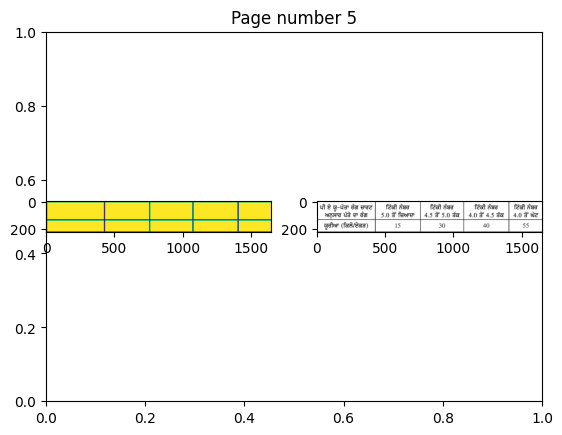

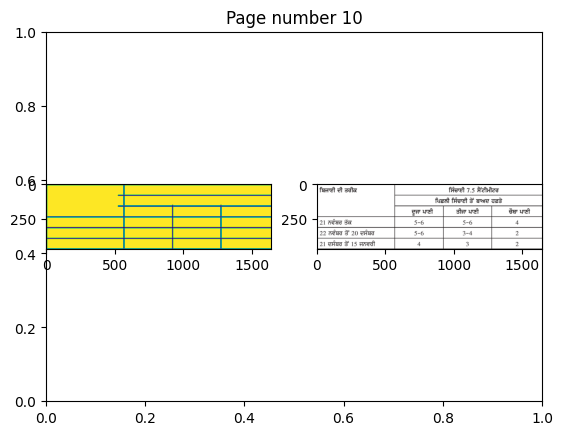

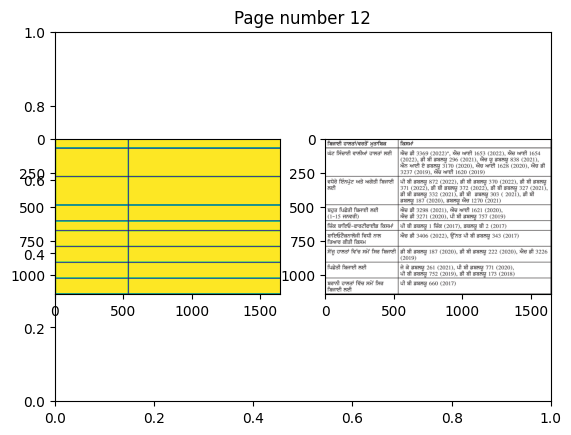

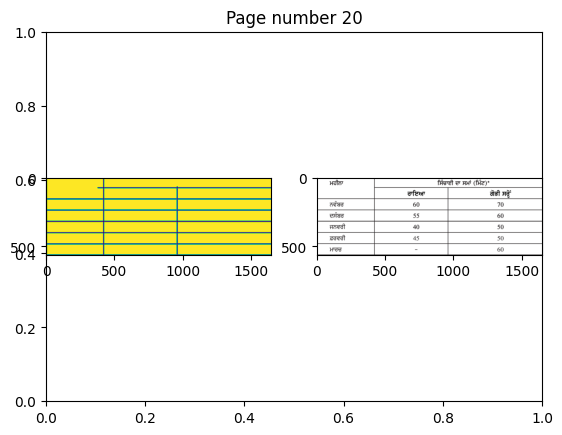

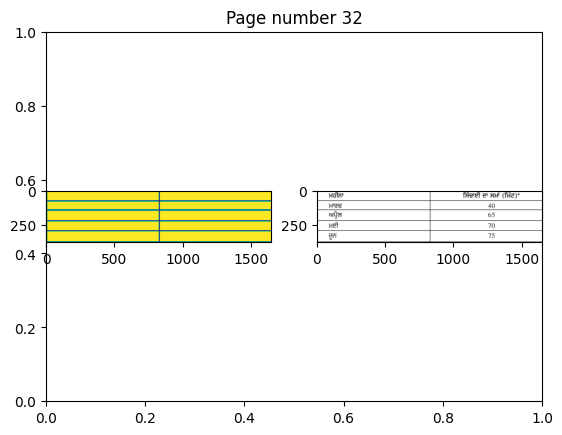

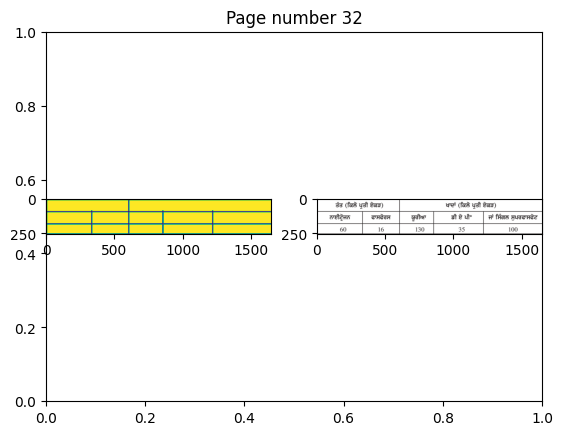

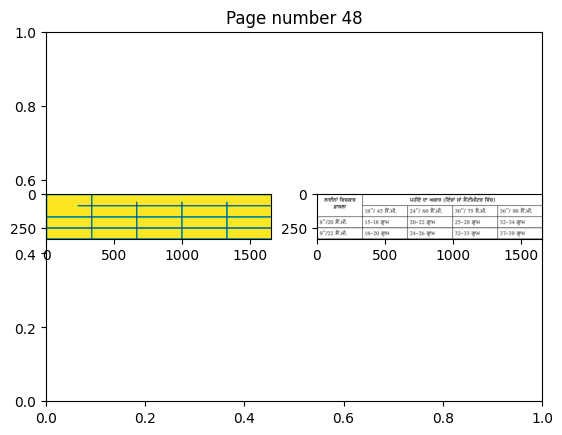

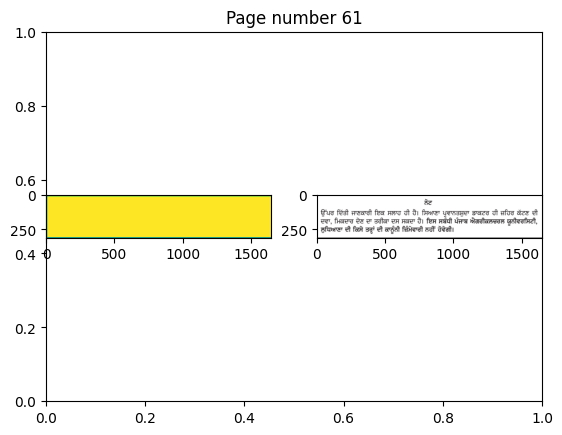

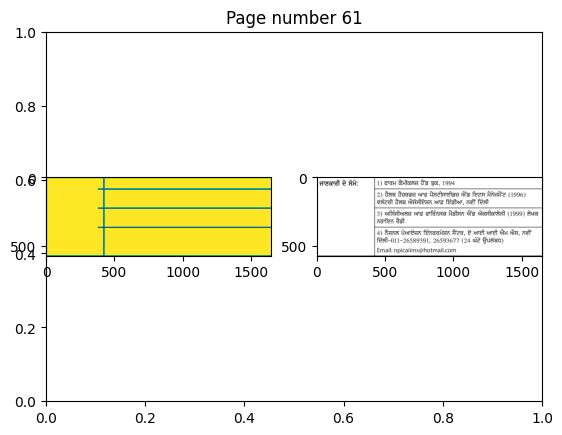

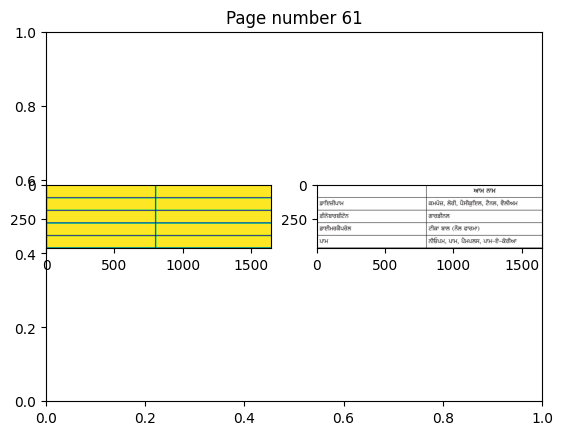

In [123]:
for idx,page in enumerate(final_table_to_be_edited):
    for table in page:
        plt.title(f'Page number {final_error[idx]}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table,15,20,40,60))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [124]:
all_text = ''
for idx,table in enumerate(final_table_to_be_edited):
    all_text = all_text + f'page-{final_error[idx]}\n'
#     print(len(table))
    if (len(table)>3):
        print(error_page[idx],len(table))
    else:
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,15,20,30,60)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                # print(ocr)
            except:
                continue
    all_text = all_text + '\n\n\n\n'

(240, 1) (1649, 220)
(1071, 1) (1645, 468)
(1107, 63) (1649, 1140)
(1222, 67) (1649, 564)
(816, 1) (1650, 376)
(1038, 1) (1648, 253)
(1315, 1) (1657, 327)
(1639, 1) (1650, 312)
(1220, 77) (1649, 572)
(843, 1) (1650, 465)


In [125]:
print(all_text)

page-5
,,,,,,
,ਪੀ ਏ ਯੂ-ਪੱਤਾ ਰੰਗ ਚਾਰਟਅਨੁਸਾਰ ਪੱਤੇ ਦਾ ਰੰਗ,ਟਿੱਕੀ ਨੰਬਰ5.0 ਤੋਂ ਜ਼ਿਆਦਾ,ਟਿੱਕੀ ਨੰਬਰ4.5 ਤੋਂ 5.0 ਤੱਕ,ਟਿੱਕੀ ਨੰਬਰ4.0 ਤੋਂ 4.5 ਤੱਕ,ਟਿੱਕੀ ਨੰਬਰ4.0 ਤੋਂ ਘੋਟ,
,ਯੂਰੀਆ (ਕਿਲੋ/ਏਕੜ),15,30,40,55,





page-10
,,,,,
,ਬਿਜਾਈ ਦੀ ਤਰੀਕ,ਸਿੰਚਾਈ 7.5 ਸੈਂਟੀਮੀਟਰ,ਸਿੰਚਾਈ 7.5 ਸੈਂਟੀਮੀਟਰ,ਸਿੰਚਾਈ 7.5 ਸੈਂਟੀਮੀਟਰ,
,ਬਿਜਾਈ ਦੀ ਤਰੀਕ,,,,
,ਬਿਜਾਈ ਦੀ ਤਰੀਕ,ਦੂਜਾ ਪਾਣੀ,ਤੀਜਾ ਪਾਣੀ,ਚੌਥਾ ਪਾਣੀ,
,21 ਨਵੰਬਰ ਤੱਕ,5-6,5-6,4,
,22 ਨਵੰਬਰ ਤੋਂ 20 ਦਸੰਬਰ,5-6,3-4,2,
,21 ਦਸੰਬਰ ਤੋਂ 15 ਜਨਵਰੀ,4,3,2,





page-12
ਬਿਜਾਈ ਹਾਲਤਾਂ/ਵਰਤੋਂ ਮੁਤਾਬਿਕ,ਕਿਸਮਾਂ,
,ਐਚ ਡੀ 3369 (2022)", ਐਚ ਆਈ 1653 (2022), ਐਚ ਆਈ 1654(2022), ਡੀ ਬੀ ਡਬਲਯੂ 296 (2021), ਐਚ ਯੂ ਡਬਲਯੂ 838 (2021),ਐਨ ਆਈ ਏ ਡਬਲਯੂ 3170 (2020), ਐਚ ਆਈ 1628 (2020), ਐਚ ਡੀ3237 (2019), ਐਚ ਆਈ 1620 (2019),
ਵਧੇਰੇ ਇੰਨਪੁੱਟ ਅਤੇ ਅਗੇਤੀ ਬਿਜਾਈਲਈ,ਪੀ ਬੀ ਡਬਲਯੂ 872 (2022), ਡੀ ਬੀ ਡਬਲਯੂ 370 (2022), ਡੀ ਬੀ ਡਬਲਯੂ371 (2022), ਡੀ ਬੀ ਡਬਲਯੂ 372 (2022), ਡੀ ਬੀ ਡਬਲਯੂ 327 (2021),ਡੀ ਬੀ ਡਬਲਯੂ 332 (2021), ਡੀ ਬੀ ਡਬਲਯੂ 303 ( 2021), ਡੀ ਬੀਡਬਲਯੂ 187 (2020), ਡਬਲਯੂ ਐਚ 1270 (2021),
ਬਹੁਤ ਪਿਛੇਤੀ ਬਿਜਾਈ ਲਈ(1-15 ਜਨਵਰੀ),ਐਚ ਡੀ 3298 (2021), ਐਚ ਆਈ 1621 (2020),ਐਚ ਡੀ 3271 (

In [126]:
output_file="data_books/ocr_punjabi/pp_rabi_tables_error_update.txt"
f= open(output_file,'a+')
f.write(all_text)
f.close()

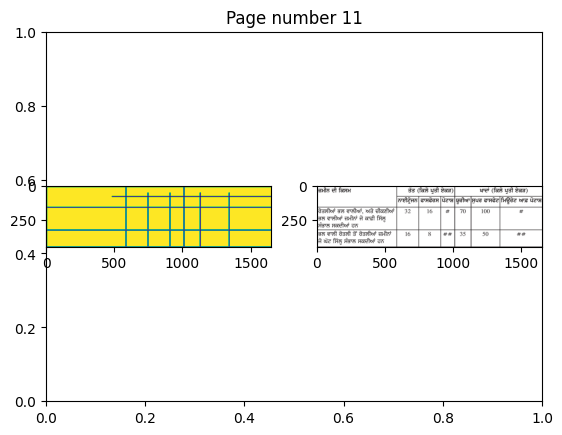

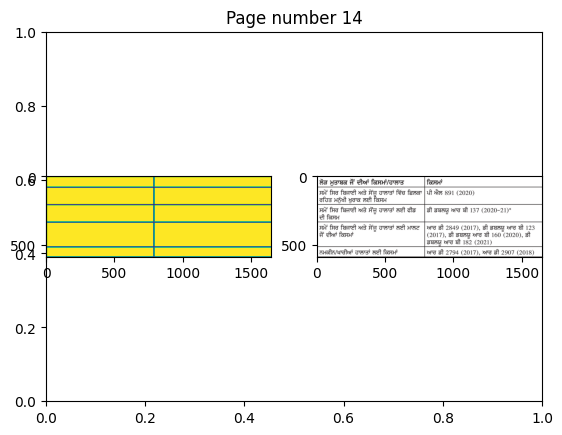

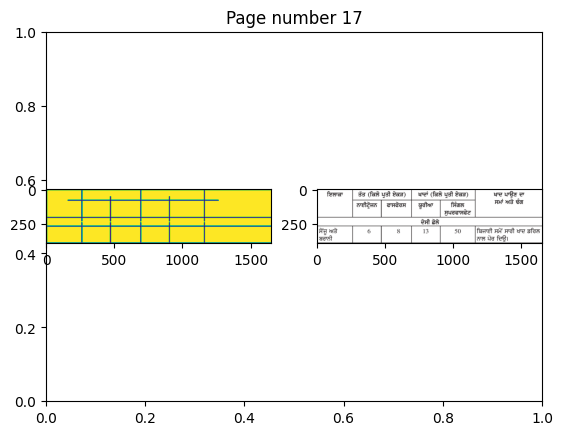

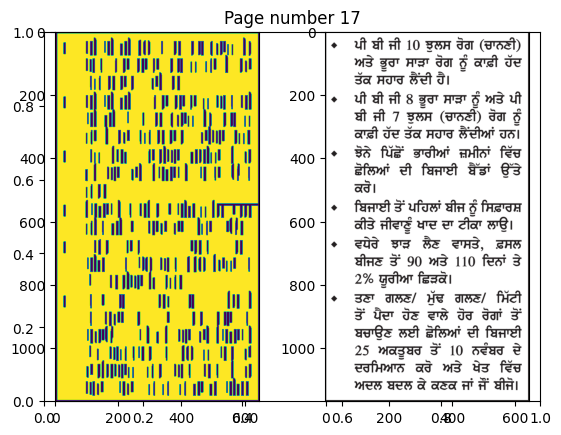

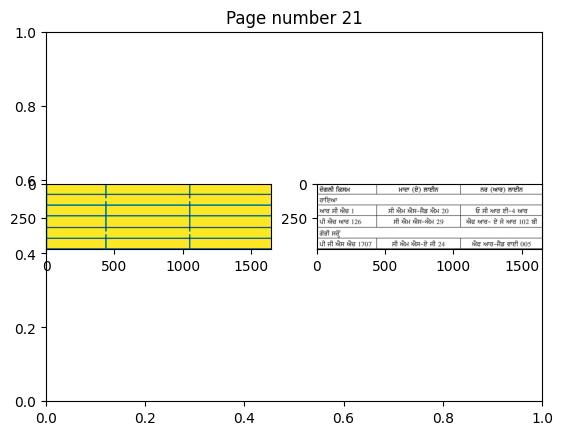

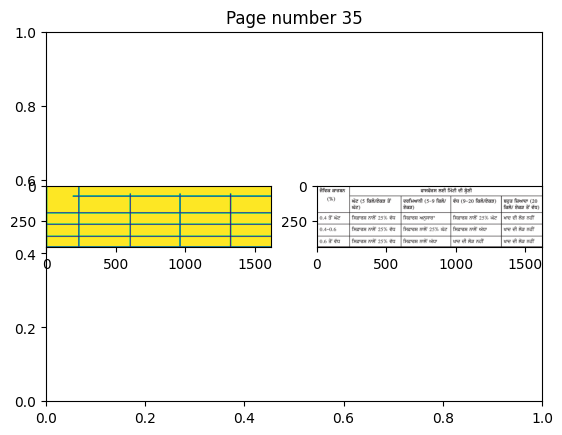

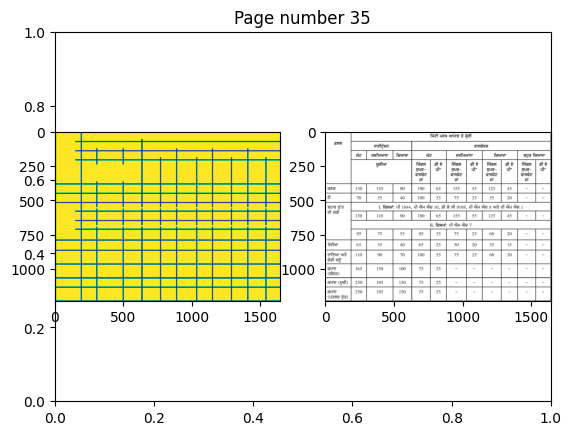

In [215]:
for idx,page in enumerate(final_table_to_edited_2):
    for table in page:
        plt.title(f'Page number {final_error_2[idx]}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table,5,10,40,60))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [216]:
all_text = ''
for idx,table in enumerate(final_table_to_edited_2):
    all_text = all_text + f'page-{final_error_2[idx]}\n'
#     print(len(table))
    if (len(table)>3):
        print(error_page[idx],len(table))
    else:
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,5,10,40,60)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                # print(ocr)
            except:
                continue
    all_text = all_text + '\n\n\n\n'

(637, 1) (1654, 445)
(855, 71) (1649, 587)
(488, 1) (1654, 396)
(635, 1159) (645, 1169)


 n


(594, 1) (1650, 478)
(1379, 1) (1621, 443)
(1447, 66) (1645, 1235)


In [217]:
print(all_text)

page-11
,,,,,,,,
,ਜ਼ਮੀਨ ਦੀ ਕਿਸਮ,ਤੱਤ (ਕਿਲੋ ਪ੍ਰਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪ੍ਰਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪ੍ਰਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),
,ਜ਼ਮੀਨ ਦੀ ਕਿਸਮ,ਨਾਈਟੋਜਨ,ਫਾਸਫੋਰਸ,ਪੋਟਾਸ਼,ਯੂਰੀਆ,ਸੁਪਰ ਫਾਸਫੇਟ,ਮਿਊਰੇਟ ਆਫ਼ ਪੌਟਾਸ਼,
,ਭਲ ਵਾਲੀਆਂ ਜ਼ਮੀਨਾਂ ਜੋ ਕਾਫ਼ੀ ਸਿੱਲ੍ਹਸੰਭਾਲ ਸਕਦੀਆਂ ਹਨ,32,16,ਤੱ,70,100,ਤੱ,
,ਜੋ ਘੱਟ ਸਿੱਲ੍ਹ ਸੰਭਾਲ ਸਕਦੀਆਂ ਹਨ,16,ਠੈ,ਤਾ,35,50,ਤਾ,





page-14
,ਕਿਸਮਾਂ,
ਰਹਿਤ ਮਨੁੱਖੀ ਖੁਰਾਕ ਲਈ ਕਿਸਮ,ਪੀ ਐਲ 891 (2020),
ਸਮੇਂ ਸਿਰ ਬਿਜਾਈ ਅਤੇ ਸੱਜੂ ਹਾਲਾਤਾਂ ਲਈ ਫੀਡਦੀ ਕਿਸਮ,ਡੀ ਡਬਲਯੂ ਆਰ ਬੀ 137 (2020-21)",
,ਆਰ ਡੀ 2849 (2017), ਡੀ ਡਬਲਯੂ ਆਰ ਬੀ 123(2017), ਡੀ ਡਬਲਯੂ ਆਰ ਬੀ 160 (2020), ਡੀਡਬਲਯੂ ਆਰ ਬੀ 182 (2021),
ਨਮਕੀਨ/ਖਾਰੀਆਂ ਹਾਲਾਤਾਂ ਲਈ ਕਿਸਮਾਂ,ਆਰ ਡੀ 2794 (2017), ਆਰ ਡੀ 2907 (2018),





page-17
,,,,,,,
,ਇਲਾਕਾ,ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਤੱਤ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦਾਂ (ਕਿਲੋ ਪੁਤੀ ਏਕੜ),ਖਾਦ ਪਾਉਣ ਦਾਸਮਾਂ ਅਤੇ ਢੰਗ,
,ਇਲਾਕਾ,ਨਾਈਟ੍ਰੋਜਨ,ਫਾਸਫੋਰਸ,ਯੂਰੀਆ,ਸਿੰਗਲਸੁਪਰਫਾਸਫੇਟ,ਖਾਦ ਪਾਉਣ ਦਾਸਮਾਂ ਅਤੇ ਢੰਗ,
,ਦੇਸੀ ਛੋਲੇ,ਦੇਸੀ ਛੋਲੇ,ਦੇਸੀ ਛੋਲੇ,ਦੇਸੀ ਛੋਲੇ,ਦੇਸੀ ਛੋਲੇ,ਦੇਸੀ ਛੋਲੇ,
,ਸੇਂਜੂ ਅਤੇਬਰਾਨੀ,6,ਠੈ,13,50,ਬਿਜਾਈ ਸਮੇਂ ਸਾਰੀ ਖਾਦ ਡਰਿਲਨਾਲ ਪੌਰ ਦਿ

In [55]:
output_file="data_books/ocr_punjabi/pp_rabi_tables_error_update.txt"
f= open(output_file,'a+')
f.write(all_text)
f.close()

In [114]:
final_error_2=[11,14,17,21,35]

In [128]:
final_table_to_edited_2=[tables[i] for i in final_error_2]

In [175]:
image = final_table_to_edited_2[0][0]
# image = cv2.imread(image)
img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
thresh1,img = cv2.threshold(img,128,255,cv2.THRESH_OTSU)
img = cv2.bitwise_not(img)
kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
vertical_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, img.shape[1]//150))
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (np.array(img).shape[1]//150, 1))

In [204]:
vertical_lines = cv2.erode(img, vertical_kernel, iterations=4)
vertical_lines = cv2.dilate(vertical_lines, vertical_kernel, iterations=10)

In [205]:
horizontal_lines = cv2.erode(img, hor_kernel, iterations=40)
horizontal_lines = cv2.dilate(horizontal_lines, hor_kernel, iterations=40)

In [206]:
vertical_horizontal_lines = cv2.addWeighted(vertical_lines, 0.5, horizontal_lines, 0.5, 0.0)
vertical_horizontal_lines = cv2.erode(~vertical_horizontal_lines, kernel, iterations=3)

In [207]:
thresh, vertical_horizontal_lines = cv2.threshold(vertical_horizontal_lines,128,255,cv2.THRESH_OTSU)
b_image = cv2.bitwise_not(cv2.bitwise_xor(img,vertical_horizontal_lines))


In [208]:
np.shape(img)

(445, 1654)

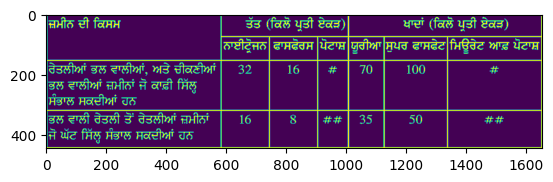

In [209]:
plt.imshow(img)

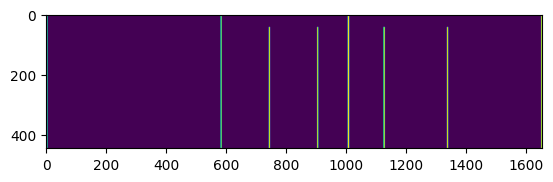

In [210]:
plt.imshow(vertical_lines)

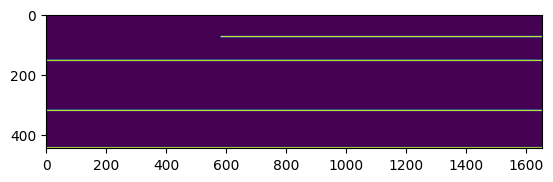

In [211]:
plt.imshow(horizontal_lines)

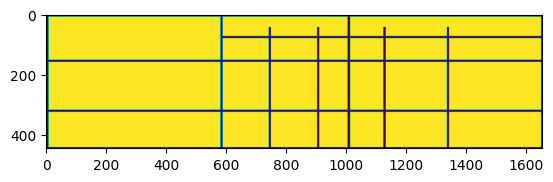

In [212]:
plt.imshow(vertical_horizontal_lines)

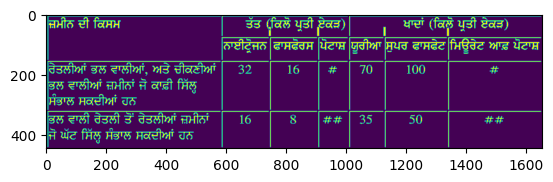

In [213]:
plt.imshow(b_image)

In [7]:
len(images)

69

In [25]:
missing_tables=[17,19,21]
# plt.imshow(images[17])

In [26]:
missing_tables_to_be_edited=[tables[i] for i in missing_tables]

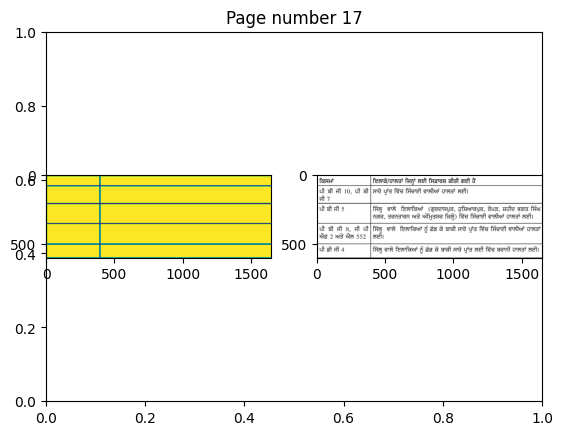

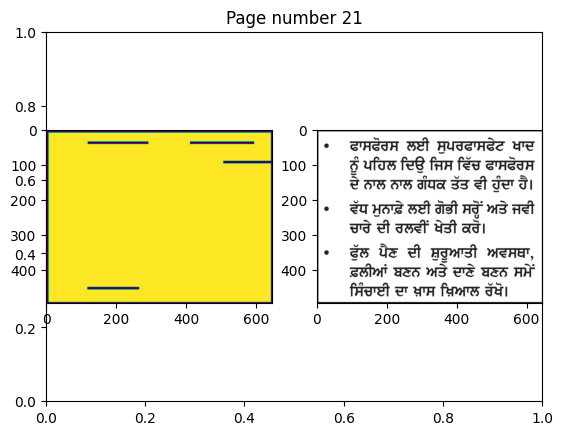

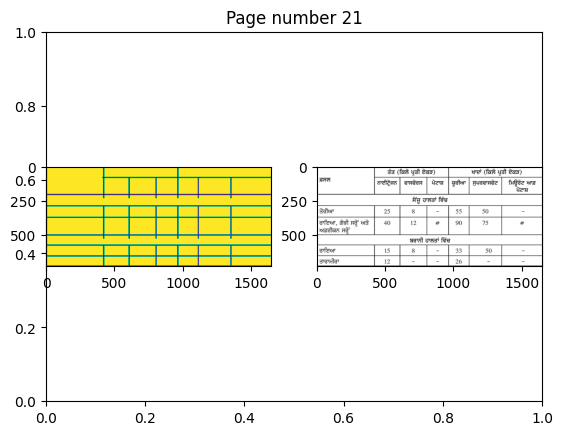

In [49]:
for idx,page in enumerate(missing_tables_to_be_edited):
    for table in page:
        plt.title(f'Page number {missing_tables[idx]}')
        plt.subplot(121)
        plt.imshow(get_cells_coordinates(table,13,15,35,45))

        plt.subplot(122)
        plt.imshow(table)

        plt.show()

In [53]:
all_text = ''
for idx,table in enumerate(missing_tables_to_be_edited):
    all_text = all_text + f'page-{missing_tables[idx]}\n'
#     print(len(table))
    if (len(table)>3):
        print(error_page[idx],len(table))
    else:
        for curr in table:
            try:
                bounding_boxes = get_cells_coordinates_include_verification(curr,5,10,35,45)
                ocr = get_text_csv(bounding_boxes,curr)
                all_text = all_text + ocr + '\n'
                # print(ocr)
            except:
                continue
    all_text = all_text + '\n\n\n\n'

(1249, 67) (1649, 605)
(635, 484) (645, 494)


 n


(680, 73) (1649, 730)
